In [1]:
import numpy as np
import pandas as pd
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    def __init__(self, path='eth.txt', min_length = 2):
        self.min_length = min_length
        self.data = pd.read_csv(path, names=['frame_number',
                                             'pedestrian_ID',
                                             'pos_x',
                                             'pos_z',
                                             'pos_y',
                                             'v_x',
                                             'v_z',
                                             'v_y'], delimiter='\s+')
        self.data.dropna()
        self.peds = self.data['pedestrian_ID'].unique()

        train_split = int(len(self.peds) * 0.5)
        train_peds, test_peds = self.peds[:train_split], self.peds[train_split:]

        self.train = self.get_trajectory(2, train_peds)
        self.test = self.get_trajectory(30, test_peds)

        print(f'Data <x, y, delta_x, delta_y>: {self.train.shape, self.test.shape}')
    
    def get_trajectory(self, min_length, peds):
        trajectories = []
        for ped in peds:
            temp = self.data[self.data.pedestrian_ID == ped][['pos_x', 'pos_y']].to_numpy()
            if temp.shape[0] < min_length:
                continue
            else:
                segments = int((temp.shape[0] // min_length) * min_length)
                temp = temp[:segments]
                temp = np.split(temp, temp.shape[0] // min_length)

            trajectories.extend(temp)

        trajectories = np.stack(trajectories, axis=0)
        displacements = trajectories[:, 1:] - trajectories[:, :-1]
        data = np.concatenate((trajectories[:, :-1], displacements), axis=-1)
        return data

    def get_train_data(self):
        return self.train[:, :, 0], self.train[:, :, 1], self.train[:, :, 2], self.train[:, :, 3]
    
    def get_test_data(self):
        return self.test[:, :, 0], self.test[:, :, 1], self.test[:, :, 2], self.test[:, :, 3]

dataset = Dataset()

Data <x, y, delta_x, delta_y>: ((2061, 1, 4), (55, 29, 4))


In [3]:
X_tr, Y_tr, DX_tr, DY_tr = dataset.get_train_data()
X_te, Y_te, DX_te, DY_te = dataset.get_test_data()

In [4]:
kernel = lambda : gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
# kernel = lambda : gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(10.0, (1e-3, 1e3))

In [5]:
model_x = gp.GaussianProcessRegressor(kernel=kernel(), n_restarts_optimizer=20, alpha=0.1, normalize_y=True)
model_x.fit(X_tr, DX_tr)

model_y = gp.GaussianProcessRegressor(kernel=kernel(), n_restarts_optimizer=20, alpha=0.1, normalize_y=True)
model_y.fit(Y_tr, DY_tr)

/home/sriyash/anaconda3/envs/crowdsim/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/sriyash/anaconda3/envs/crowdsim/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

In [6]:
X_te1, DX_te1 = X_te.reshape((-1, 1)), DX_te.reshape((-1, 1))
Y_te1, DY_te1 = Y_te.reshape((-1, 1)), DY_te.reshape((-1, 1))

x_pred, std = model_x.predict(X_te1, return_std=True)
y_pred, std = model_y.predict(Y_te1, return_std=True)

MSE_x = ((x_pred-DX_te1)**2).mean()
MSE_y = ((y_pred-DY_te1)**2).mean()
MSE_x, MSE_y

(0.28535073785115034, 0.027062973281235313)

In [11]:

def plot(X, Y, model_x, model_y, one_step=True):
    if one_step:
        x_pred, x_std = model_x.predict(X[:, None], return_std=True)
        y_pred, y_std = model_y.predict(Y[:, None], return_std=True)
    else:
        x_pred, x_std = unroll(X[0], model_x, X.shape[0])
        y_pred, y_std = unroll(Y[0], model_y, Y.shape[0])

    x_max, x_min = x_pred+x_std, x_pred-x_std
    y_max, y_min = y_pred+y_std, y_pred-y_std

    X_pred = X+x_pred[:, 0]
    Y_pred = Y+y_pred[:, 0]

    X_min = X+x_min[:, 0]
    Y_min = Y+y_min[:, 0]

    X_max = X+x_max[:, 0]
    Y_max = Y+y_max[:, 0]

    plt.figure()
    plt.plot(X, Y, linestyle='--', color='C1', label='truth')
    plt.plot(X_pred, Y_pred, linestyle='-', color='C1', label='prediction')
    plt.fill_between(X_pred, Y_min, Y_max, color='C1', alpha=0.2)
    plt.fill_betweenx(Y_pred, X_min, X_max, color='C1', alpha=0.2)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title(f'Trajectory Prediction')
    plt.show()

    truth = np.stack((X, Y), axis=-1)
    prediction = np.stack((X_pred, Y_pred), axis=-1)

    return np.linalg.norm(truth-prediction, axis=-1).mean(), np.linalg.norm(truth[-1]-prediction[-1], axis=-1).mean()

def unroll(X, model, T):
    X = X[None, None]
    preds = []
    stds = []
    for _ in range(T):
        pred, std = model.predict(X, return_std=True)
        preds.append(pred)
        stds.append(std)
        X += pred
    return np.concatenate(preds, axis=0), np.concatenate(stds, axis=0)


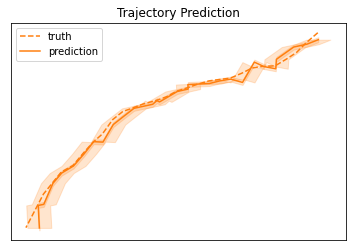

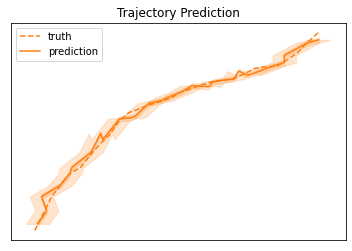

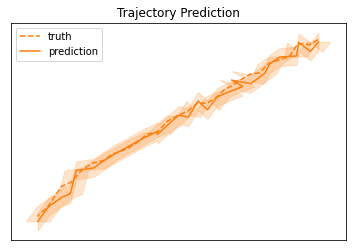

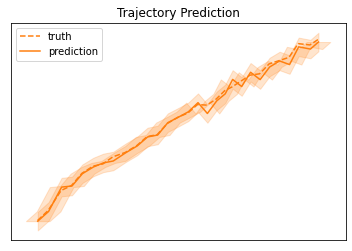

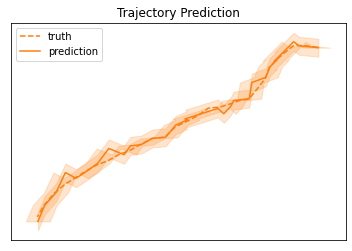

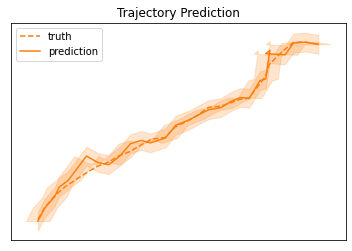

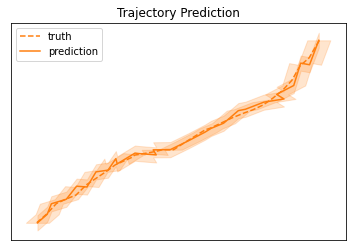

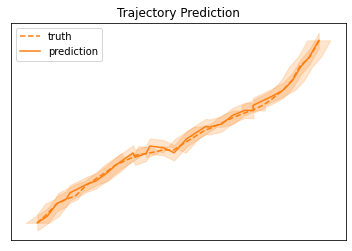

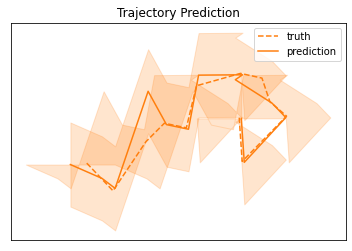

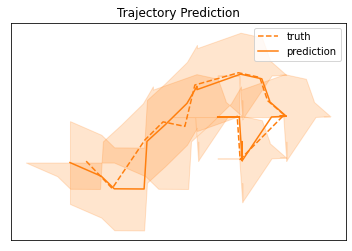

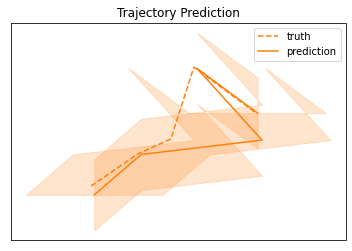

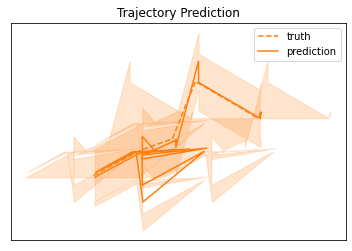

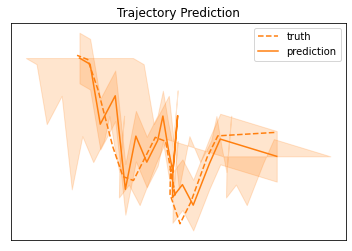

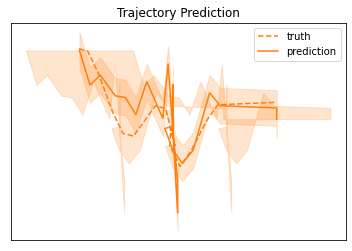

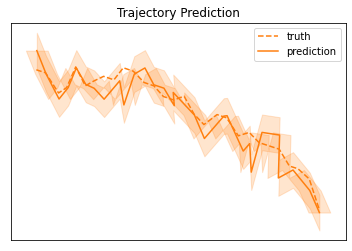

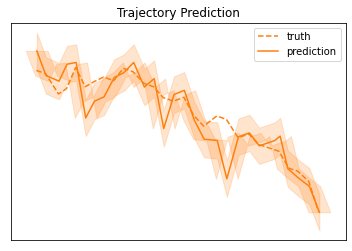

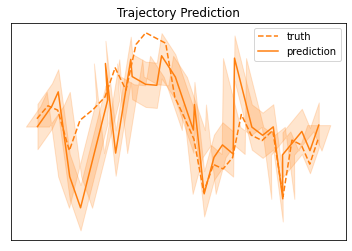

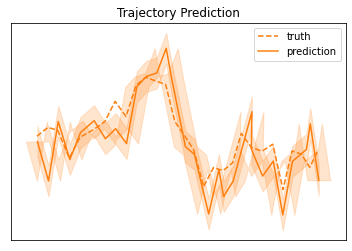

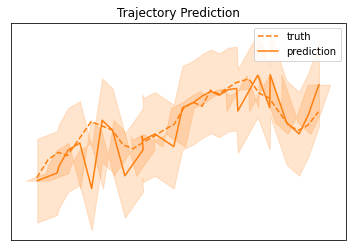

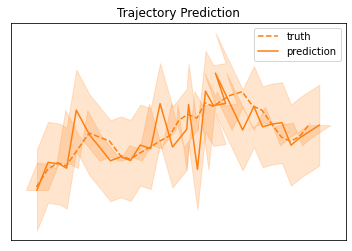

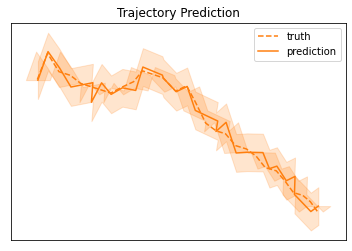

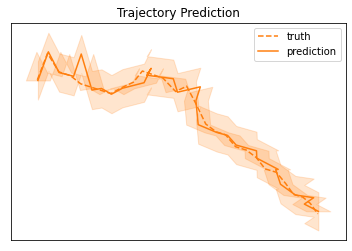

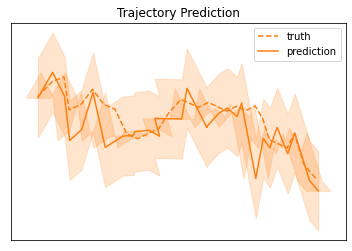

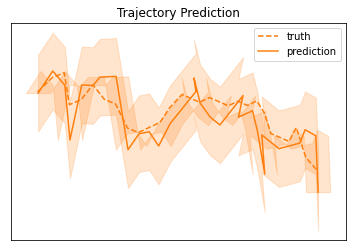

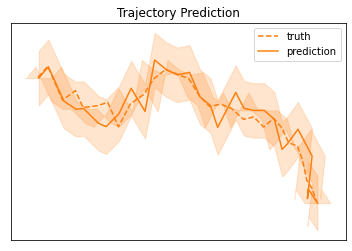

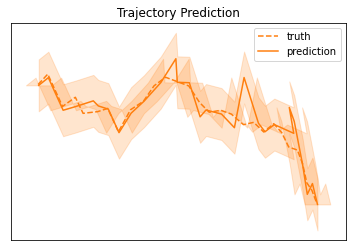

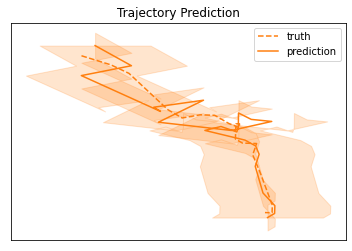

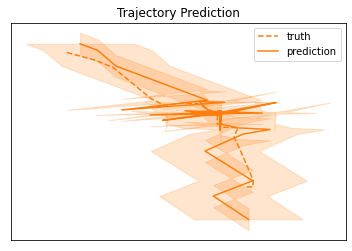

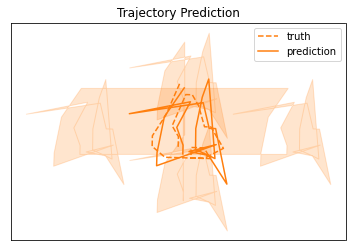

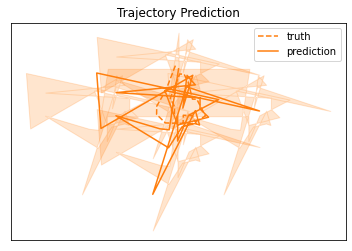

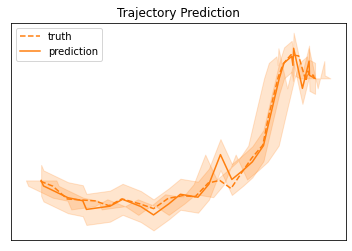

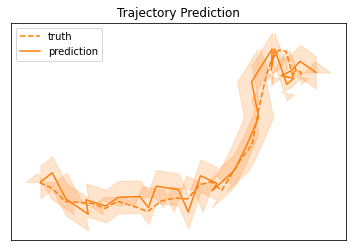

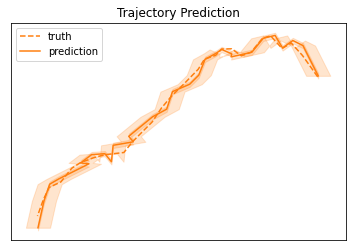

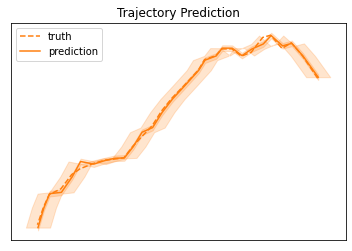

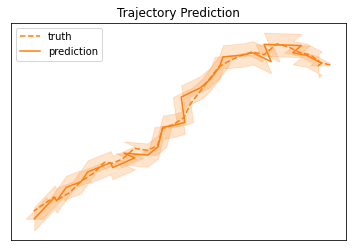

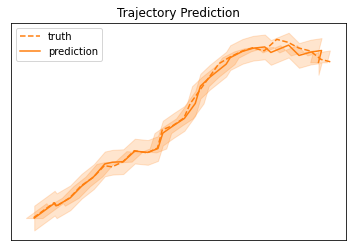

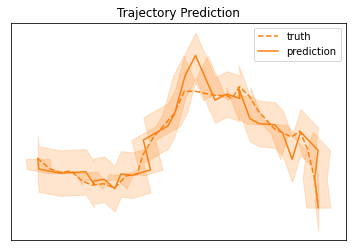

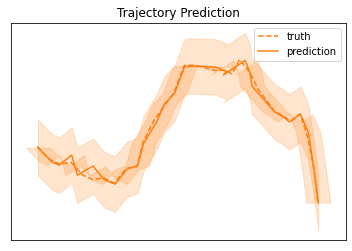

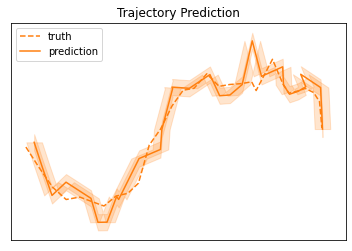

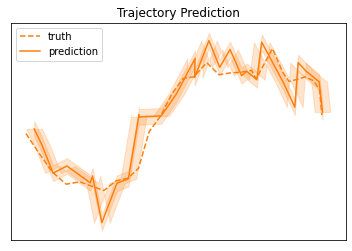

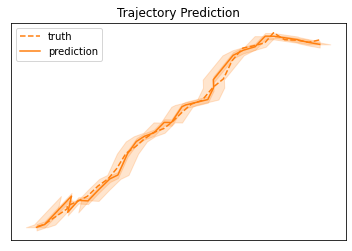

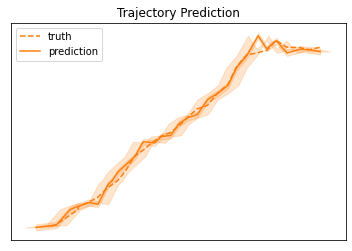

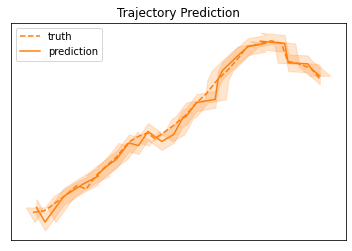

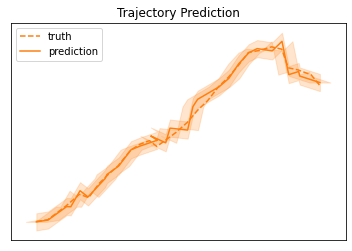

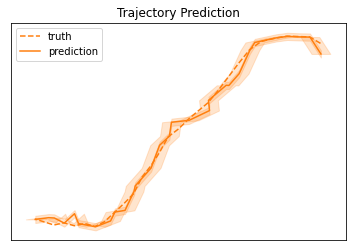

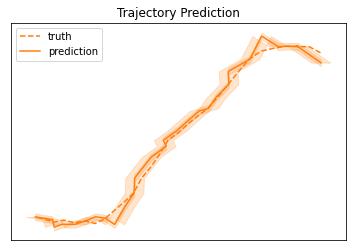

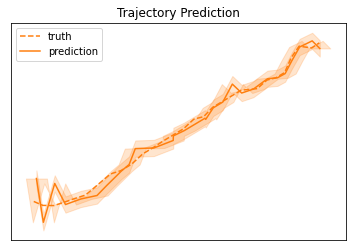

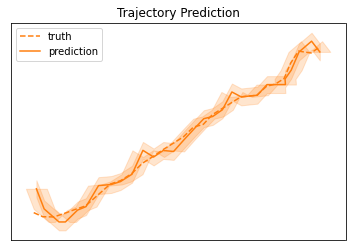

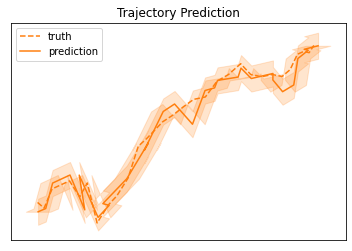

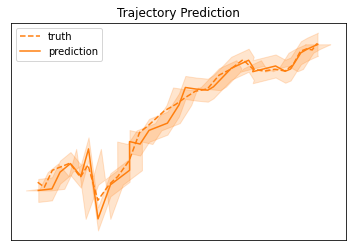

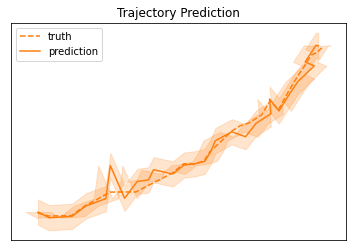

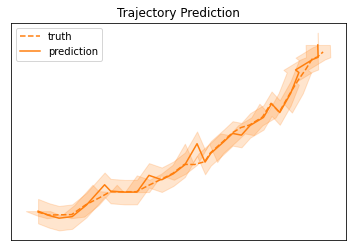

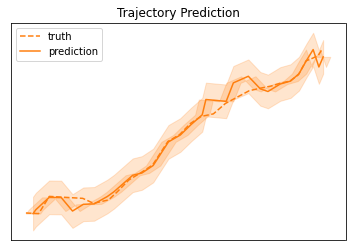

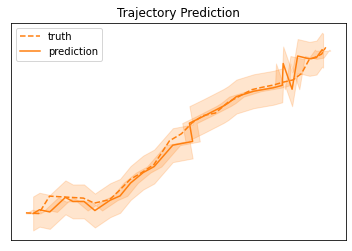

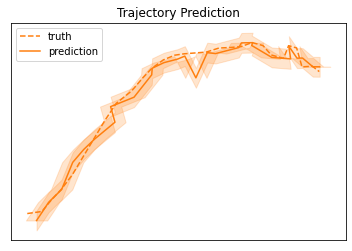

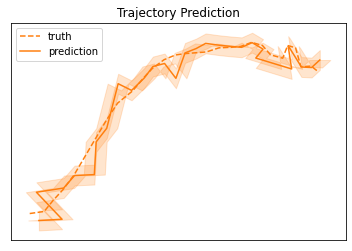

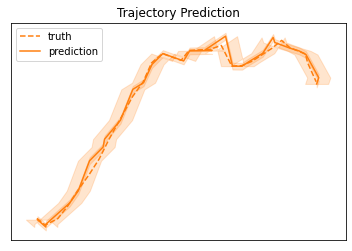

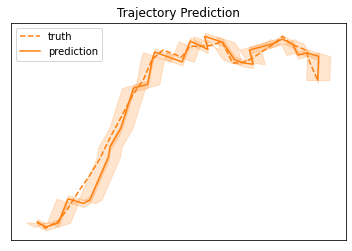

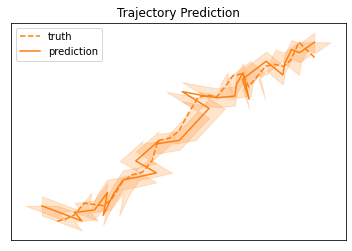

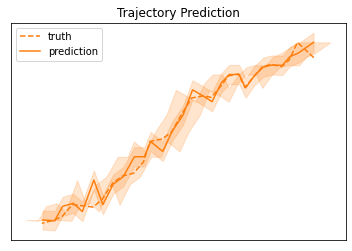

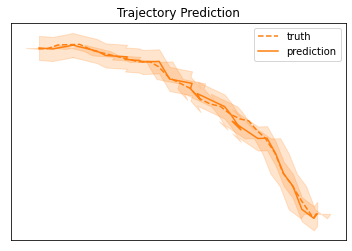

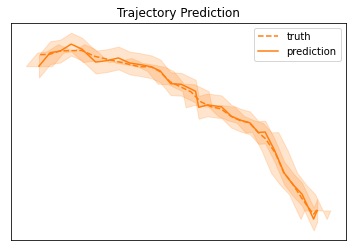

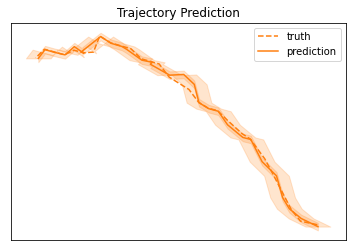

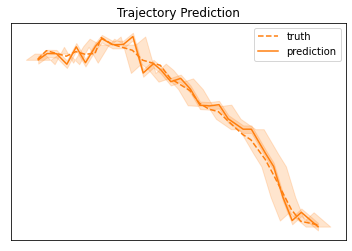

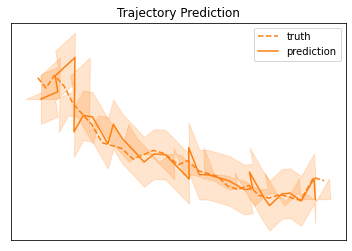

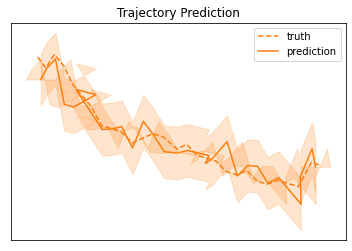

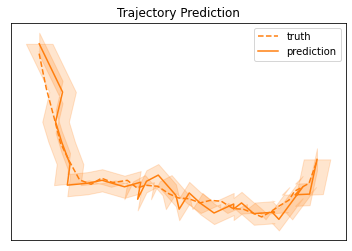

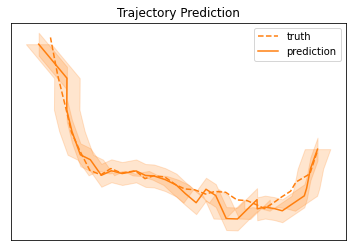

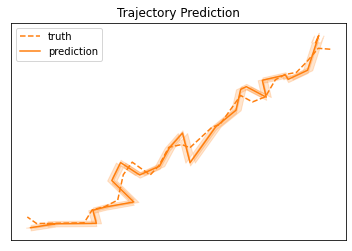

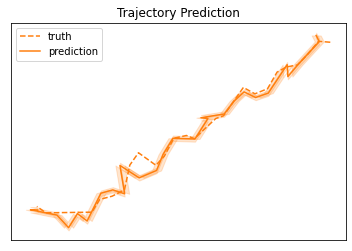

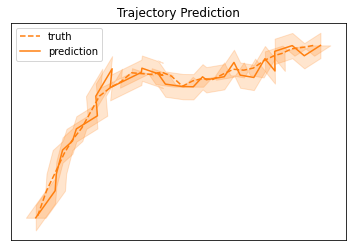

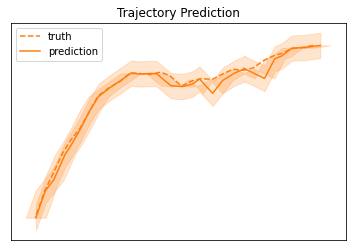

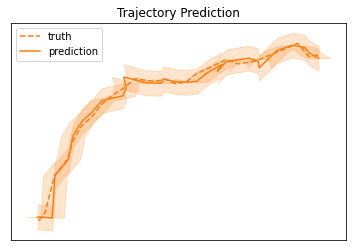

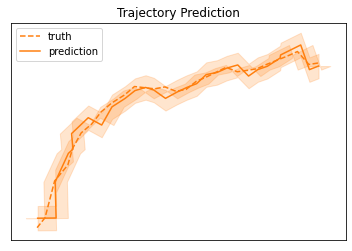

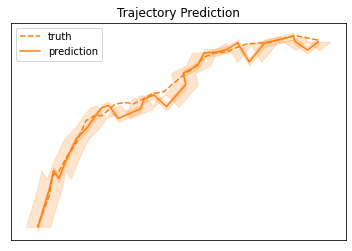

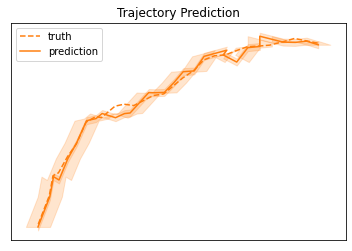

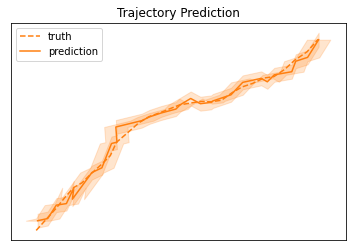

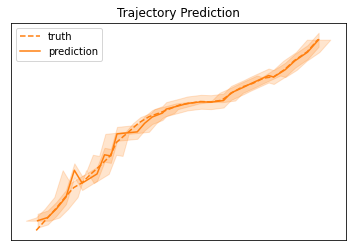

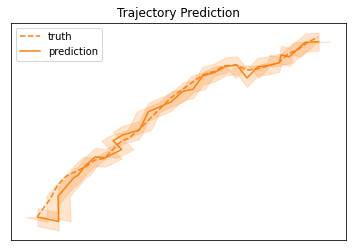

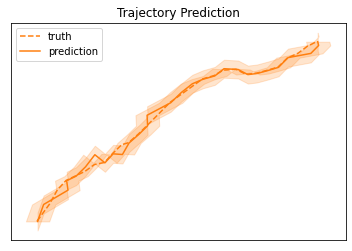

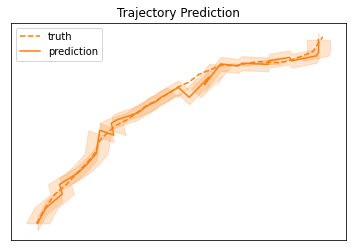

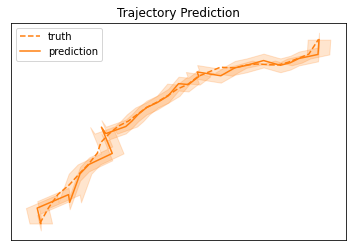

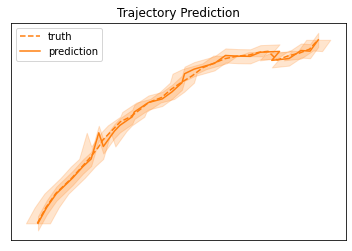

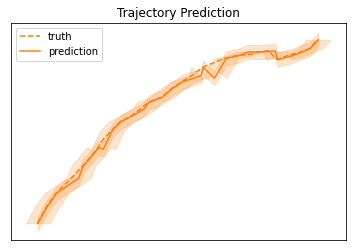

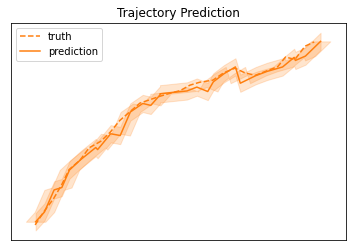

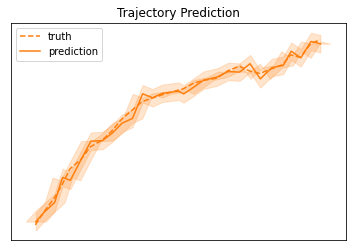

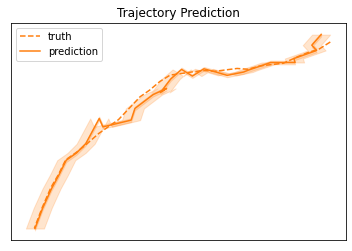

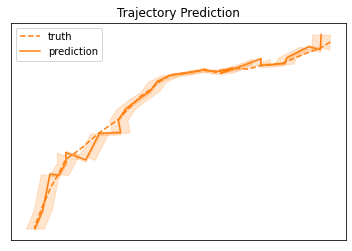

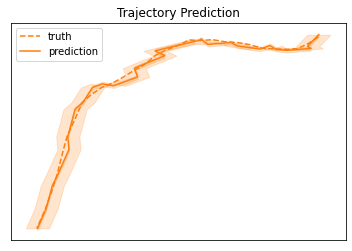

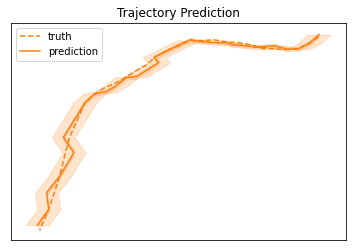

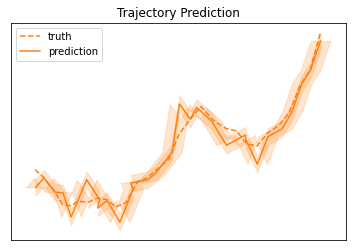

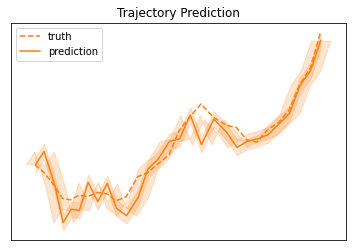

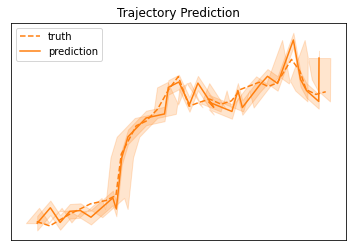

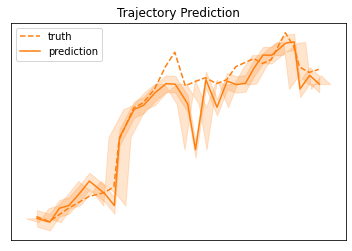

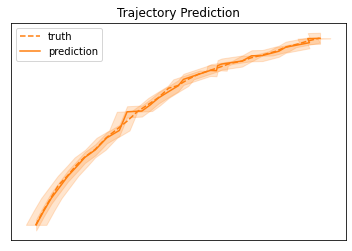

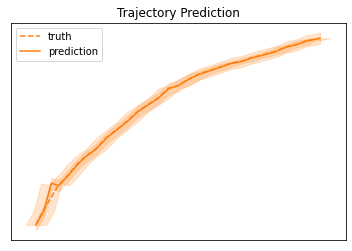

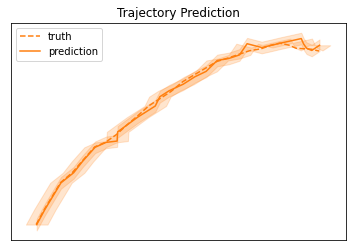

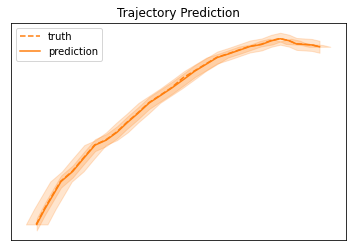

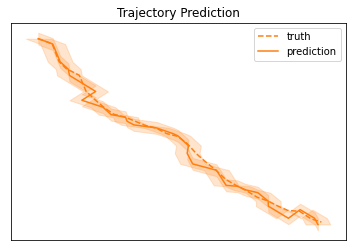

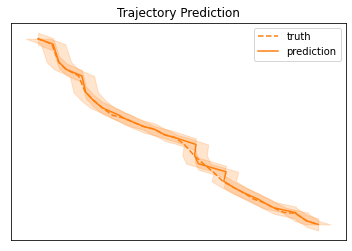

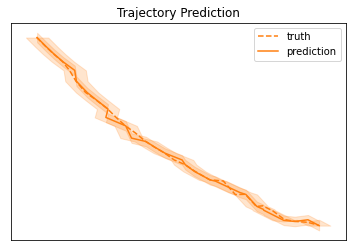

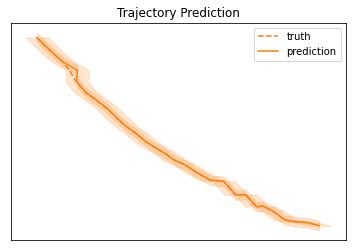

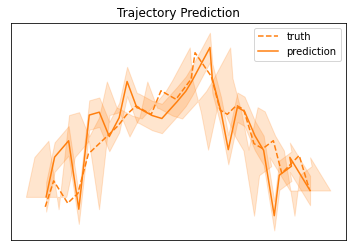

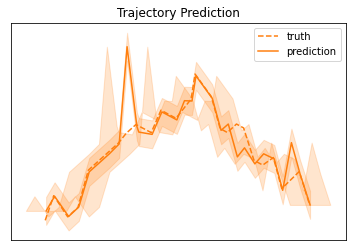

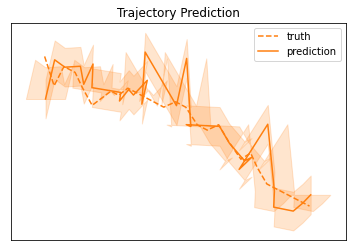

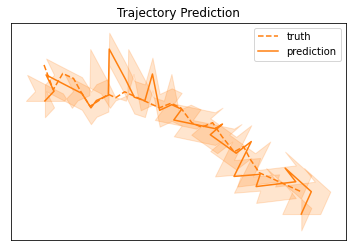

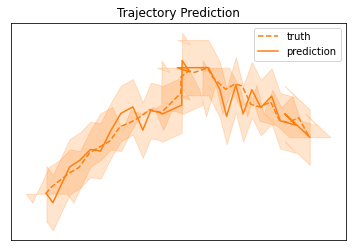

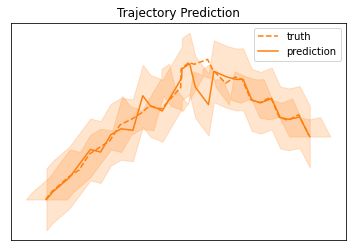

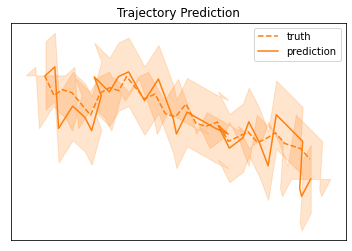

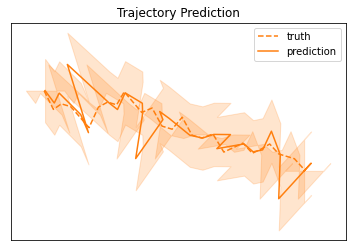

onestep 0.1636941345120929 0.11901024863034398
unroll 0.12577204959611493 0.10930514103624552


In [12]:
onestep_m = dict(ade=[], fde=[])
unroll_m = dict(ade=[], fde=[])

for i in range(X_te.shape[0]):
    a, f = plot(X_te[i], Y_te[i], model_x, model_y)
    a_, f_ = plot(X_te[i], Y_te[i], model_x, model_y, False)
    onestep_m['ade'].append(a)
    unroll_m['ade'].append(a_)
    onestep_m['fde'].append(f)
    unroll_m['fde'].append(f_)

print('onestep', np.array(onestep_m['ade']).mean(), np.array(onestep_m['fde']).mean())
print('unroll', np.array(unroll_m['ade']).mean(), np.array(unroll_m['fde']).mean())

In [9]:
# X_te = X_te.cumsum(axis=1)
# y_te = y_te.cumsum(axis=1)
# y_pred = y_pred.cumsum(axis=1)

# for i in range(X_te.shape[0]):
#     plt.figure()
#     plt.plot(X_te[i], y_te[i], linestyle='--', color='C1', label='truth')
#     plt.plot(X_te[i], y_pred[i], linestyle='-', color='C1', label='prediction')
#     plt.legend()
#     plt.title(f'Trajectory Prediction {i}')
#     plt.show()
# X_te.shape